In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.drop(['Id'], axis = 'columns', inplace = True)
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,30,0,Non-Travel,Research & Development,2,3,Medical,571,3,Female,...,3,0,12,2,11,7,6,7,4,1
1,36,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,3,Female,...,3,2,7,2,3,2,1,1,2,1
2,55,1,Travel_Rarely,Sales,2,1,Medical,842,3,Male,...,3,0,12,3,9,7,7,3,5,1
3,39,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,1,Male,...,3,0,18,2,7,7,1,7,4,1
4,37,0,Travel_Rarely,Research & Development,3,3,Other,689,3,Male,...,3,1,10,2,10,7,7,8,1,1


In [3]:
df.drop_duplicates(inplace=True)

In [4]:
from sklearn.preprocessing import LabelEncoder

for column in df.columns:
  if df[column].dtype == int:
    continue
  df[column] = LabelEncoder().fit_transform(df[column])
     

In [5]:
df.YearsAtCompany = np.sqrt(df.YearsAtCompany)
df.TotalWorkingYears = np.sqrt(df.TotalWorkingYears)
df.Age = pd.Series(stats.boxcox(df.Age)[0])
df.MonthlyIncome = pd.Series(stats.boxcox(df.MonthlyIncome)[0])
df.YearsSinceLastPromotion = np.sqrt(df.YearsSinceLastPromotion)

ValueError: Data must be positive.

In [ ]:
X = df.drop(['Attrition'], axis = 1)
y = df['Attrition']

In [ ]:
from sklearn.feature_selection import RFE
gb_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, random_state=0)
rfe = RFE(estimator=gb_clf, n_features_to_select=18)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[ True False False  True False  True  True  True False  True  True  True
  True  True  True  True  True False  True  True  True  True False  True
 False False False]
[ 1  3  7  1  6  1  1  1  8  1  1  1  1  1  1  1  1  9  1  1  1  1  4  1
  5  2 10]


In [ ]:
cols = [col for col in X[X.columns[rfe.support_]].columns]
cols.remove('Age')
cols.remove('EmployeeNumber')
cols.remove('PercentSalaryHike')
cols.remove('MonthlyIncome')
cols.remove('JobRole')

X = X[cols]
     

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.332351
         Iterations 7
                            Results: Logit
Model:                Logit              Method:             MLE       
Dependent Variable:   Attrition          Pseudo R-squared:   0.235     
Date:                 2023-08-31 20:08   AIC:                690.7016  
No. Observations:     1000               BIC:                754.5024  
Df Model:             12                 Log-Likelihood:     -332.35   
Df Residuals:         987                LL-Null:            -434.66   
Converged:            1.0000             LLR p-value:        3.6221e-37
No. Iterations:       7.0000             Scale:              1.0000    
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
DistanceFromHome         0.0458   0.0118  3.8695 0.0001  0.0226

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25, random_state = 41)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.metrics import roc_auc_score

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_features=9, max_depth=7, random_state=0)
gb_clf.fit(X_train, y_train)
roc_auc_score(gb_clf.predict(X_test), y_test)
     

0.6878768974838845

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(GradientBoostingClassifier(n_estimators=1000,learning_rate=0.05, max_features=9, max_depth=7),X, y, cv=5, scoring= 'roc_auc')
scores.mean()

0.7296686893286614

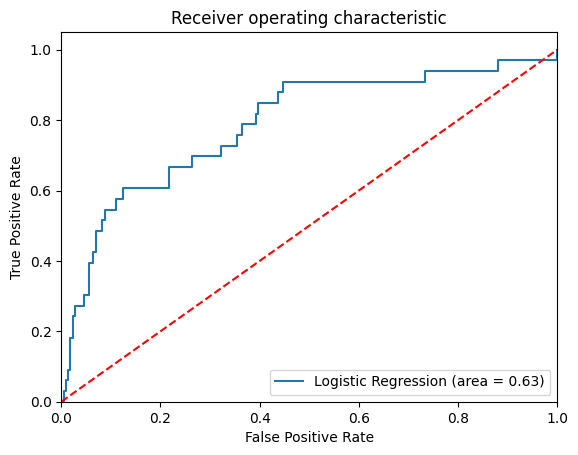

In [ ]:
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, gb_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [ ]:
test = pd.read_csv('./test.csv')
test.drop('Id', axis = 1,inplace = True)
for column in test.columns:
  if test[column].dtype == int:
    continue
  test[column] = LabelEncoder().fit_transform(test[column])

test.YearsAtCompany = np.sqrt(test.YearsAtCompany)
test.TotalWorkingYears = np.sqrt(test.TotalWorkingYears)
test.Age = pd.Series(stats.boxcox(test.Age)[0])
test.MonthlyIncome = pd.Series(stats.boxcox(test.MonthlyIncome)[0])
test.YearsSinceLastPromotion = np.sqrt(test.YearsSinceLastPromotion)

test = test[cols]
# test = pd.get_dummies(test, columns=[ 'MaritalStatus'], drop_firs

In [ ]:
sol = gb_clf.predict_proba(test)
sol1 = pd.DataFrame(sol[:,1:])
sol1['Id'] = np.arange(1, 471)
sol1['Attrition'] = sol1[0]
sol1.drop(0, axis = 1, inplace = True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '{title}'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = sol1

# create a link to download the dataframe
create_download_link(df)